In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,classification_report
from sklearn.metrics import SCORERS
import lightgbm as lgb
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df=pd.read_csv("hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
#Null value Treatment
df.drop('company',axis="columns",inplace=True) #94% Null value we cant use these column or 
#otherwise we will ask more data to the client at these situation.
df['children']=df['children'].fillna(0) 
df['country']=df['country'].fillna("Unknown")
df['agent']=df['agent'].fillna(0)

In [4]:
filter = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
df = df[~filter]
df.drop(columns=['reservation_status'], axis=1, inplace=True)
df.dropna(subset=['country', 'children'], axis=0, inplace=True)
df.drop(df[df['adr'] < 0].index, inplace=True, axis=0)

In [5]:
df['distribution_channel'].value_counts()

TA/TO        97750
Direct       14610
Corporate     6651
GDS            193
Undefined        5
Name: distribution_channel, dtype: int64

Contract - when the booking has an allotment or other type of contract associated to it;

Group – when the booking is associated to a group;

Transient – when the booking is not part of a group or contract, and is not associated to other transient booking;

Transient-party – when the booking is transient, but is associated to at least other transient booking

In [6]:
df[df['distribution_channel'] == 'Undefined']
df.drop(df[df['distribution_channel'] == 'Undefined'].index, inplace=True, axis=0)

In [7]:
#Removing Duplicates
df=df.drop(df[df.duplicated()].index,axis=0)

Changing Data Types

In [8]:
categorical=df[['agent','arrival_date_month','arrival_date_year',
                'assigned_room_type','country','customer_type',
                'deposit_type','distribution_channel','is_repeated_guest','market_segment',
                'meal','reserved_room_type']]
numerical=df[['adr','adults','arrival_date_day_of_month','arrival_date_week_number',
              'arrival_date_year','babies','booking_changes'
             ,'children','days_in_waiting_list','lead_time',
              'previous_bookings_not_canceled','previous_cancellations','required_car_parking_spaces','stays_in_weekend_nights',
              'stays_in_week_nights','total_of_special_requests']]
date=df['reservation_status_date']

for i in categorical.columns:
    df[i]=df[i].astype('object')
for i in numerical.columns:
    df[i]=df[i].astype(np.number)
df['reservation_status_date']=pd.to_datetime(df['reservation_status_date'])
df['arrival_date_year']=df['arrival_date_year'].astype('object')


# Stats

In [9]:
#Statistical test for categorical

from scipy import stats as st
pvalue=[]
for i in df.select_dtypes('object').columns:
    x=pd.crosstab(df[i],df['is_canceled'])
    stats,pv,dof,expected_value=st.chi2_contingency(x)
    pvalue.append(pv)
    
p=pd.DataFrame()
p['columns']=df.select_dtypes('object').columns
p['pvalue']=pvalue
p

,columns,pvalue
0,hotel,1.581381e-100
1,arrival_date_year,3.583225e-148
2,arrival_date_month,2.280554e-129
3,meal,2.880279e-77
4,country,0.000000e+00
5,market_segment,0.000000e+00
6,distribution_channel,0.000000e+00
7,is_repeated_guest,3.710820e-151
8,reserved_room_type,2.045211e-55
9,assigned_room_type,1.100583e-151


In [10]:
#Anova test
from sklearn.feature_selection import SelectKBest,f_classif,chi2
anova=SelectKBest(score_func=f_classif)
anova.fit(numerical,df['is_canceled'])

pv1=pd.DataFrame()
pv1['Columns']=numerical.columns
pv1['Pvalues']=round(pd.Series(anova.pvalues_),2)
pv1

,Columns,Pvalues
0,adr,0.00
1,adults,0.00
2,arrival_date_day_of_month,0.11
3,arrival_date_week_number,0.62
4,arrival_date_year,0.00
5,babies,0.00
6,booking_changes,0.00
7,children,0.00
8,days_in_waiting_list,0.16
9,lead_time,0.00


In [11]:
df1=df.copy()
df1.drop(['arrival_date_week_number','days_in_waiting_list','reservation_status_date'],axis='columns',inplace=True)

# Encoding

In [12]:
for i in df1.select_dtypes('object'):
    print(i,df1[i].nunique())

hotel 2
arrival_date_year 3
arrival_date_month 12
meal 5
country 178
market_segment 7
distribution_channel 4
is_repeated_guest 2
reserved_room_type 9
assigned_room_type 11
deposit_type 3
agent 334
customer_type 4


In [13]:
df1['hotel']=pd.get_dummies(df1['hotel'],drop_first=True)
df1['is_repeated_guest']=pd.get_dummies(df['is_repeated_guest'],drop_first=True)

In [14]:
df1['arrival_date_year']=list(map(lambda x:int(x),df1['arrival_date_year']))
df1['arrival_date_day_of_month']=list(map(lambda x:int(x),df1['arrival_date_day_of_month']))
df1['arrival_date_month'].replace({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,
                                      'August':8,'September':9,'October':10,'November':11,'December':12},inplace=True)
col=['arrival_date_year','arrival_date_day_of_month','arrival_date_month']
df1['Date_of_arrival']=df1[col].apply(lambda x:'-'.join (x.values.astype(str)),axis='columns')
df2=df1.drop(["arrival_date_year",'arrival_date_day_of_month','arrival_date_month'],axis='columns')

In [15]:
#Date of arrival 
#Checking Significance
df=df2.drop('Date_of_arrival',axis='columns')
observed_value=pd.crosstab(df2['Date_of_arrival'],df2['is_canceled'])
stats,pvalue,dof,expected_value=st.chi2_contingency(observed_value)
pd.Series(pvalue)



0    2.158697e-220
dtype: float64

In [16]:
for i in df1.select_dtypes('object'):
    print(i,df1[i].nunique())

meal 5
country 178
market_segment 7
distribution_channel 4
reserved_room_type 9
assigned_room_type 11
deposit_type 3
agent 334
customer_type 4
Date_of_arrival 793


In [17]:
#country column
Antartica=['ATA','BVT','ATF','HMD','SGS']
Aus=['ASM','AUS','COK','FJI','PYF','GUM','KIR','MHL','FSM','NRU','NCL','NZL','NIU','NFK','MNP','PLW','PNG','PCN','WSM','SLB',
     'TKL','TON','TUV','UMI','VUT','WLF']
Asia=['AFG','AZE','BHR','BGD','BTN','CN','IOT','BRN','KHM','CHN','CXR','CCK','CYP','GEO','HKG','IND','IDN','IRN','IRQ','ISR','JPN',
      'JOR','KAZ','PRK','KOR','KWT','KGZ','LAO','LBN','MAC','MYS',
      'MDV','MNG','MMR','NPL','OMN','PAK','PSE','PHL','QAT','SAU','SGP','TMP','LKA','SYR','TWN','TJK','THA','TLS','TUR','TKM','ARE',
       'UZB','VNM','YEM']
Europe=['ALA','ALB','AND','ARM','AUT','BLR','BEL','BIH','BGR','HRV','CZE','DNK','EST','FRO','FIN','FRA','DEU','GIB','GRC','GGY',
        'VAT','HUN','ISL','IRL','IMN','ITA','JEY','LVA','LIE','LTU','LUX','MKD','MLT','MDA','MCO','MNE','NLD','NOR','POL','PRT',
         'ROU','RUS','SMR','SRB','SVK','SVN','ESP','SJM','SWE','CHE','UKR','GBR']
NA=['AIA','ABW','BHS','BRB','BES','CAN','CRI','CUB','CUW','CYM','DMA','DOM','SLV','GRL','GRD','GLP','GTM','HTI','HND','JAM','MTQ','MEX','MSR','ANT',
    'NIC','PAN','PRI','BLM','KNA','LCA','MAF','SPM','VCT','VGB','SXM','TTO','TCA','UMI','USA','VIR']
SA=['ARG','BOL','BRA','CHL','COL','ECU','FLK','GUF','GUY','PRY','PER','SUR','URY','VEN']
Africa=['DZA','AGO','BEN','BWA','BFA','BDI','CMR','CPV','CAF','TCD','COM','COG','COD','CIV','DJI','EGY','GNQ','ERI','ETH',
        'GAB','GMB','GHA','GIN','GNB','KEN','LSO','LBR','LBY','MDG','MWI','MLI','MRT','MUS','MYT','MAR','MOZ','NAM','NER',
        'NGA','REU','RWA','SHN','STP','SEN','SYC','SLE','SOM','ZAF','SSD','SDN','SWZ','TZA','TGO','TUN','UGA','ESH','ZMB',
        'ZWE']

for i in df['country']:
    if i in Europe:
        df['country'].replace({i:'Europe'},inplace=True)
    elif i in Antartica:
        df['country'].replace({i:'Antartica'},inplace=True)
    elif i in Asia:
        df['country'].replace({i:'Asia'},inplace=True)
    elif i in NA:
        df['country'].replace({i:'North_America'},inplace=True)
    elif i in SA:
        df['country'].replace({i:'South_America '},inplace=True)
    elif i in Aus:
        df['country'].replace({i:'Australia'},inplace=True)
    elif i in Africa:
        df['country'].replace({i:'Africa'},inplace=True)
        

In [18]:
#checking for country significance to our Target Variable
observed_value=pd.crosstab(df['country'],df['is_canceled'])
stats,pvalue,dof,expected_value=st.chi2_contingency(observed_value)
round(pd.Series(pvalue),2)

#It is significant

0    0.0
dtype: float64

In [19]:
df['country'].value_counts(normalize=True)

Europe            0.884871
Asia              0.041805
South_America     0.028034
North_America     0.023264
Africa            0.011741
Australia         0.005125
Unknown           0.005125
Antartica         0.000034
Name: country, dtype: float64

In [20]:
#Frequency Encoding on Country
df['country'].replace({'Europe':0,'Asia':1,'South_America ':1,'North_America':1,'Africa':1,'Unknown':2,'Australia':2,'Antartica':2},inplace=True)

In [21]:
df['country'].value_counts(normalize=True)

0    0.884871
1    0.104844
2    0.010285
Name: country, dtype: float64

In [22]:
for i in df.select_dtypes('object'):
    print(i,df[i].nunique())

meal 5
market_segment 7
distribution_channel 4
reserved_room_type 9
assigned_room_type 11
deposit_type 3
agent 334
customer_type 4


In [23]:
dummy1=pd.get_dummies(df['meal'],drop_first=True)
df=pd.concat([df,dummy1],axis=1)
df.drop('meal',axis='columns',inplace=True)

In [24]:
df['market_segment'].value_counts(normalize=True)
df['market_segment'].replace({"Online TA":0,'Offline TA/TO':1,'Direct':1,'Groups':2,'Corporate':2,'Complementary':3,'Aviation':3},inplace=True)

In [25]:
for i in df.select_dtypes('object'):
    print(i,df[i].nunique())

distribution_channel 4
reserved_room_type 9
assigned_room_type 11
deposit_type 3
agent 334
customer_type 4


In [26]:
dummy2=pd.get_dummies(df['distribution_channel'],drop_first=True)
df=pd.concat([df,dummy2],axis=1)
df.drop('distribution_channel',axis='columns',inplace=True)

In [27]:
df['deposit_type'].replace({"No Deposit":0,'Non Refund':1,'Refundable':1},inplace=True)

In [28]:
for i in df.select_dtypes('object'):
    print(i,df[i].nunique())

reserved_room_type 9
assigned_room_type 11
agent 334
customer_type 4


In [29]:
df.drop('agent',axis='columns',inplace=True)

In [30]:
for i in df.select_dtypes('object'):
    print(i,df[i].nunique())

reserved_room_type 9
assigned_room_type 11
customer_type 4


In [31]:
# Feature Extracting
def family(data):
    if ((data['adults'] > 0) & (data['children'] > 0)):
        val = 1
    elif ((data['adults'] > 0) & (data['babies'] > 0)):
        val = 1
    else:
        val = 0
    return val
df['new_is_family'] = df.apply(family, axis=1)
df.drop(["adults",'children','babies'],axis='columns',inplace=True)

In [32]:
df.shape

(87215, 26)

In [33]:
from sklearn.preprocessing import LabelEncoder
ll=LabelEncoder()
df['reserved_room_type']=ll.fit_transform(df[['reserved_room_type']])
df['assigned_room_type']=ll.fit_transform(df[['assigned_room_type']])
df['customer_type']=ll.fit_transform(df[['customer_type']])

In [38]:
new_df=df

# Model Building LOGISTIC REGRESSION


In [39]:
x=new_df.drop('is_canceled',axis='columns')
y=new_df['is_canceled']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=10)

Train~results
[[44000  3346]
 [11745  6320]]
              precision    recall  f1-score   support

           0       0.79      0.93      0.85     47346
           1       0.65      0.35      0.46     18065

    accuracy                           0.77     65411
   macro avg       0.72      0.64      0.65     65411
weighted avg       0.75      0.77      0.74     65411

Training accuracy 0.7693
Testing accuracy 0.7697


Test~results

[[14698  1168]
 [ 3854  2084]]
              precision    recall  f1-score   support

           0       0.79      0.93      0.85     15866
           1       0.64      0.35      0.45      5938

    accuracy                           0.77     21804
   macro avg       0.72      0.64      0.65     21804
weighted avg       0.75      0.77      0.75     21804

Plot roc curve <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x000001F1F0AC5730>


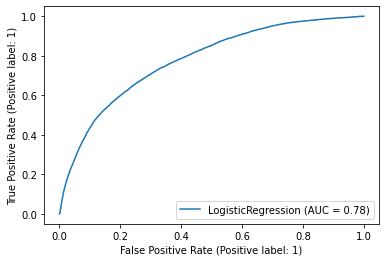

In [40]:
def function(x):
    model=x.fit(x_train, y_train)
    y_train_pred = x.predict(x_train)
    

    print('Train~results')
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

    y_test_pred = x.predict(x_test)
    
    
    
    print('Training accuracy {:.4f}'.format(x.score(x_train,y_train)))
    print('Testing accuracy {:.4f}'.format(x.score(x_test,y_test)))
    print('\n')
    print('Test~results')
    print()
    print(metrics.confusion_matrix(y_test, y_test_pred))
    print(metrics.classification_report(y_test, y_test_pred))
    
    print("Plot roc curve",metrics.plot_roc_curve(model,x_train,y_train))

function(LogisticRegression())

In [41]:
# example of grid searching key hyperparametres for logistic regression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

x, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.957667 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.948667 (0.018209) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.945000 (0.017464) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.948333 (0.017143) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.950000 (0.018974) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.947333 (0.017308) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.949000 (0.017578) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.950667 (0.018962) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.951667 (0.018634) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.949333 (0.017499) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.953000 (0.019175) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.952667 (0.018607) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.951000 (0.017195) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.957667 (0.018382) wi

In [42]:
import statsmodels.api as sm
x=new_df.drop('is_canceled',axis='columns')
y=new_df['is_canceled']
X=sm.add_constant(x)
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.25,random_state=10)

model=sm.Logit(Y_train,X_train).fit(method='bfgs')
model.summary()


         Current function value: 0.473577
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


F:\jupyter\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_canceled   No. Observations:                65411
Model:                          Logit   Df Residuals:                    65385
Method:                           MLE   Df Model:                           25
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                  0.1964
Time:                        15:36:11   Log-Likelihood:                -30977.
converged:                      False   LL-Null:                       -38547.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.0397      0.094    -11.090      0.000      -1.223      -0.856
hotel                              0.2014      0.024      8.304      0.000       0.154       0.249
lead_time                          0.0045      0.000     36.234      0.000       0.004       0.005
stays_in_weekend_nights            0.0531      0.011      4.638      0.000       0.031       0.076
stays_in_week_nights               0.0271      0.006      4.544      0.000       0.015       0.039
country                            0.1232      0.027      4.574      0.000       0.070       0.176
market_segment                    -0.8479      0.025    -33.753      0.000      -0.897      -0.799
is_repeated_guest                 -0.3868      0.102     -3.785      0.000      -0.587      -0.187
previous_cancellations             2.2618      0.080     28.409      0.000       2.106       2.418
previous_bookings_not_canceled    -0.2557      0.020    -12.628      0.000      -0.295      -0.216
reserved_room_type                 0.3933      0.016     25.015      0.000       0.362       0.424
assigned_room_type                -0.4307      0.015    -28.332      0.000      -0.461      -0.401
booking_changes                   -0.3268      0.018    -17.734      0.000      -0.363      -0.291
deposit_type                       2.6477      0.100     26.508      0.000       2.452       2.843
customer_type                      0.2068      0.021      9.915      0.000       0.166       0.248
adr                                0.0063      0.000     25.316      0.000       0.006       0.007
required_car_parking_spaces       -4.2729      0.189    -22.613      0.000      -4.643      -3.903
total_of_special_requests         -0.6026      0.014    -43.794      0.000      -0.630      -0.576
FB                                 0.0386      0.169      0.228      0.820      -0.293       0.370
HB                                -0.2805      0.036     -7.719      0.000      -0.352      -0.209
SC                                 0.2951      0.031      9.376      0.000       0.233       0.357
Undefined                         -0.0467      0.158     -0.295      0.768      -0.357       0.264
Direct                            -0.8709      0.070    -12.498      0.000      -1.008      -0.734
GDS                               -0.2184      0.194     -1.127      0.260      -0.598       0.161
TA/TO                             -0.6784      0.072     -9.434      0.000      -0.819      -0.537
new_is_family                      0.3297      0.035      9.492      0.000       0.262       0.398
==================================================================================================
"""

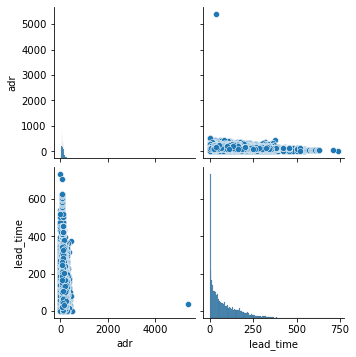

In [43]:
sns.pairplot(new_df[['adr','lead_time']])

#Lot of over lapping is there it is an non linear Model

In [36]:
new_df.to_csv("model.csv",header=True,index=False)

In [ ]:
x=new_df.drop('is_canceled',axis='columns')
y=new_df['is_canceled']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=10)

In [ ]:
import lightgbm as lgb
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-9,random_state=10)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='roc_auc')

In [ ]:
lgb.plot_importance(model,figsize=(18,16))

In [45]:
def function(x):
    x.fit(x_train, y_train)
    y_train_pred = x.predict(x_train)
    

    print('Train~results')
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

    y_test_pred = x.predict(x_test)
    
    
    
    print('Training accuracy {:.4f}'.format(x.score(x_train,y_train)))
    print('Testing accuracy {:.4f}'.format(x.score(x_test,y_test)))
    print('\n')
    print('Test~results')
    print()
    print(metrics.confusion_matrix(y_test, y_test_pred))
    print(metrics.classification_report(y_test, y_test_pred))

function(RandomForestClassifier())
    

Train~results
[[47227   119]
 [  298 17767]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     47346
           1       0.99      0.98      0.99     18065

    accuracy                           0.99     65411
   macro avg       0.99      0.99      0.99     65411
weighted avg       0.99      0.99      0.99     65411

Training accuracy 0.9936
Testing accuracy 0.8032


Test~results

[[14300  1566]
 [ 2724  3214]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87     15866
           1       0.67      0.54      0.60      5938

    accuracy                           0.80     21804
   macro avg       0.76      0.72      0.73     21804
weighted avg       0.79      0.80      0.80     21804



In [47]:
new_df.to_csv("final1.csv",header=True,index=False)